# ASE Interface

In [1]:
import rdkit2ase

The main functionality of `rdkit2ase` is to generate new structures from SMILES.
For this purpose, you can utilize `smiles2atoms` and `smiles2conformers`.

In [2]:
water = rdkit2ase.smiles2atoms("O")
water

Atoms(symbols='OH2', pbc=False)

In [3]:
aspirin = rdkit2ase.smiles2conformers("CC(=O)OC1=CC=CC=C1C(=O)O", numConfs=3)
aspirin

[Atoms(symbols='C2O2C7O2H8', pbc=False),
 Atoms(symbols='C2O2C7O2H8', pbc=False),
 Atoms(symbols='C2O2C7O2H8', pbc=False)]

Within `rdkit2ase` you can translate structures between ASE and rdkit.

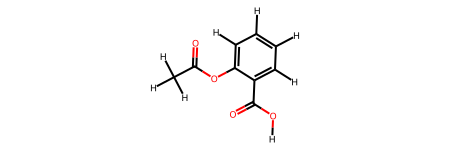

In [4]:
mol = rdkit2ase.ase2rdkit(aspirin[0])
print(mol)
mol

If a structure has been generated using `rdkit2ase` it includes `smiles` and `connectivity` in it's `atoms.info` key. This information is utilized to quickly transform `ase.Atoms` to rdkit structures.

In [5]:
aspirin[0].info

{'smiles': 'CC(=O)OC1=CC=CC=C1C(=O)O',
 'connectivity': [(0, 1, 1.0),
  (1, 2, 2.0),
  (1, 3, 1.0),
  (3, 4, 1.0),
  (4, 5, 1.5),
  (5, 6, 1.5),
  (6, 7, 1.5),
  (7, 8, 1.5),
  (8, 9, 1.5),
  (9, 10, 1.0),
  (10, 11, 2.0),
  (10, 12, 1.0),
  (9, 4, 1.5),
  (0, 13, 1.0),
  (0, 14, 1.0),
  (0, 15, 1.0),
  (5, 16, 1.0),
  (6, 17, 1.0),
  (7, 18, 1.0),
  (8, 19, 1.0),
  (12, 20, 1.0)]}

Without this information, `rdkit2ase` will try to guess the bond information. You can aid this process, by including SMILES into the `suggestions=` keyword.

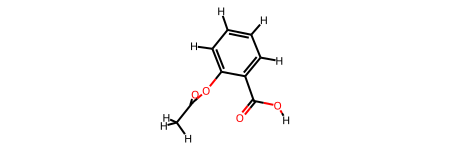

In [6]:
aspirin_0 = aspirin[0]
del aspirin_0.info["smiles"]
del aspirin_0.info["connectivity"]
rdkit2ase.ase2rdkit(aspirin_0)

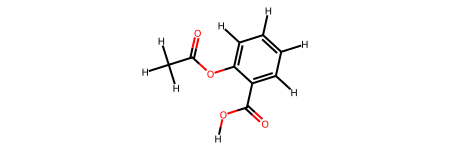

In [7]:
rdkit2ase.ase2rdkit(aspirin_0, suggestions=["CC(=O)OC1=CC=CC=C1C(=O)O"])

You can use `rdkit2ase.match_substructure` to select parts of the structure based on SMILES, SMARTS, molecules or even ase.Atoms.

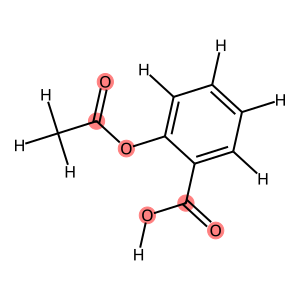

In [8]:
from rdkit.Chem import Draw

mol = rdkit2ase.ase2rdkit(aspirin_0, suggestions=["CC(=O)OC1=CC=CC=C1C(=O)O"])
Draw.MolToImage(
    mol,
    highlightAtoms={
        i
        for group in rdkit2ase.match_substructure(aspirin[0], smarts="C(=O)O")
        for i in group
    },
)